Written by Hamid Nemati (9535023)

# 1. Part Of Speech tagging with HMM (the easy way)

**Part of speech tagging is the process of determining the syntactic category of a word from the words in its surrounding context.** It is often used to help disambiguate natural language phrases because it can be done quickly with high accuracy. Tagging can be used for many NLP tasks like determining correct pronunciation during speech synthesis (for example, dis-count as a noun vs dis-count as a verb), for information retrieval, and for word sense disambiguation.

**Tagging is a disambiguation task;** words are ambiguous—have more than one possible  part-of-speech and  the  goal  is  to  find  the  correct  tag  for  the  situation. For example, book can be a verb (book that flight) or a noun (hand me that book). The accuracy of part-of-speech tagging algorithms (the percentage of test set accuracy tags that match human gold labels) is extremely high. Accuracies on various English treebanks are also 97% (no matter the algorithm; HMMs, CRFs, BERT perform similarly).

### POS-tagging fall into two distinctive groups:
    1. Rule-based POS tagger
    2. Stocastic POS tagger
    
    
**HMM (Hidden Markov Model) is a Stochastic technique for POS tagging**. Hidden Markov models are known for their applications to reinforcement learning and temporal pattern recognition such as speech, handwriting, gesture recognition, musical score following, partial discharges, and bioinformatics.  

### In Part of speech tagging:
1. **Observations** are the word themselves.
2. **Hidden states** are POS tags for the words.
3. **Transition probabilities** are the probability of current word having a tag of Verb for example  based on the tag of one or two words before,like this: P(Verb | NOUN)
4. **Emission probabilities** are the probability of the word be 'john' for example given the tag is a Noun, like this: P(John | Noun)

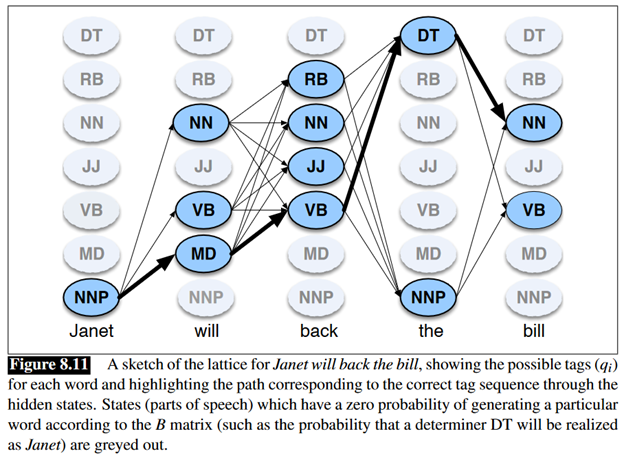

Unlike other nlp problems we don't need to remove stopwords and punctuations and there is no need for stemming or lematization too. This is because of the nature of this problem witch is to identify role of every word in a sentence.

# Reading the data

In [ ]:
#pip install pomegranate

In [1]:
import pandas as pd
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution
from sklearn.utils import shuffle
from collections import Counter, defaultdict

In [2]:
raw_data = open('hmm-training.txt').read()
raw_data[:200]

"i\tPRP\n'd\tMD\nlike\tVB\nto\tTO\ngo\tVB\nto\tIN\na\tDT\nfancy\tJJ\nrestaurant\tNN\n.\t.\n\ni\tPRP\n'd\tMD\nlike\tVB\nfrench\tJJ\nfood\tNN\n.\t.\n\nnext\tJJ\nthursday\tNN\n.\t.\n\nnext\tJJ\nthursday\tNN\n.\t.\n\ndinner\tNN\n.\t.\n\ni\tPRP\nwant\tVBP\nto\tTO\n"

In [3]:
parsed_data = raw_data.replace('\t','\n').split()
parsed_data[:10]

['i', 'PRP', "'d", 'MD', 'like', 'VB', 'to', 'TO', 'go', 'VB']

In [4]:
list_of_words = parsed_data[0::2]
list_of_tags  = parsed_data[1::2]

In [5]:
tags = list(set(list_of_tags))
print(len(tags))
print(tags)

36
['VBN', 'VBG', 'NNP', 'MD', 'CC', 'RBR', 'TO', 'NNS', 'PRP$', 'RB', 'PRP', 'LS', 'EX', 'HYPH', 'JJS', 'FW', 'DT', 'JJR', 'NN', 'IN', 'VBP', 'RP', 'WP', 'CD', 'POS', 'RBS', 'PDT', 'VBD', ':', 'WRB', 'VBZ', 'UH', 'WDT', '.', 'JJ', 'VB']


In [28]:
# Exploring the data
dict_data = pd.DataFrame({
    'word': list_of_words,
    'tag' : list_of_tags
})

print(f"Input data has {len(dict_data)} rows and {len(dict_data.columns)} columns")
print(f"Number of null values:\n{dict_data.isnull().sum()}")
dict_data.head()

Input data has 150120 rows and 2 columns
Number of null values:
word    0
tag     0
dtype: int64


,word,tag
0,i,PRP
1,'d,MD
2,like,VB
3,to,TO
4,go,VB


In [6]:
# Reshaping the data for HMM
list_of_tuples = list(zip(list_of_words, list_of_tags))
list_of_lists_of_tuples = []
temp_list=[]

for i in range(len(list_of_tuples)):
    temp_list.append(list_of_tuples[i])
    if list_of_tuples[i]==('.','.'):
        list_of_lists_of_tuples.append(temp_list)
        temp_list=[]

list_of_lists_of_tuples = shuffle(list_of_lists_of_tuples)
list_of_lists_of_tuples[0]   

[('please', 'UH'),
 ('give', 'VB'),
 ('me', 'PRP'),
 ('a', 'DT'),
 ('place', 'NN'),
 ('where', 'WRB'),
 ('i', 'PRP'),
 ('can', 'MD'),
 ('eat', 'VB'),
 ('excellent', 'JJ'),
 ('salad', 'NN'),
 ('plates', 'NNS'),
 ('.', '.')]

# Functions & HMM

In [29]:
def rearrange_data(sequences):
    x = []
    y = []
    w = set()
    t = set()
    for sequence in sequences:
        sequence_x = []
        sequence_y = []
        for word, tag in sequence:
            sequence_x.append(word)
            sequence_y.append(tag)
            w.add(word)
            t.add(tag)
        x.append(sequence_x)
        y.append(sequence_y)
    return x, y, w, t

def replace_unknown(sequence, vocabulary):
    """Return a copy of the input sequence where each unknown word is replaced
    by the literal string value 'nan'. Pomegranate will ignore these values
    during computation.
    """
    return [w if w in vocabulary else 'nan' for w in sequence]

def simplify_decoding(X, model, vocabulary):
    """X should be a 1-D sequence of observations for the model to predict"""
    _, state_path = model.viterbi(replace_unknown(X, vocabulary))
    return [state[1].name for state in state_path[1:-1]]  # do not show the start/end state predictions

def accuracy(X, Y, model, vocabulary):
    """Calculate the prediction accuracy by using the model to decode each sequence
    in the input X and comparing the prediction with the true labels in Y.
    
    The X should be an array whose first dimension is the number of sentences to test,
    and each element of the array should be an iterable of the words in the sequence.
    The arrays X and Y should have the exact same shape.
    
    X = [("See", "Spot", "run"), ("Run", "Spot", "run", "fast"), ...]
    Y = [(), (), ...]
    """
    correct = total_predictions = 0
    for observations, actual_tags in zip(X, Y):
        
        # The model.viterbi call in simplify_decoding will return None if the HMM
        # raises an error (for example, if a test sentence contains a word that
        # is out of vocabulary for the training set). Any exception counts the
        # full sentence as an error (which makes this a conservative estimate).
        try:
            most_likely_tags = simplify_decoding(observations, model, vocabulary)
            correct += sum(p == t for p, t in zip(most_likely_tags, actual_tags))
        except:
            pass
        total_predictions += len(observations)
    return correct / total_predictions

def pair_counts(sequences_A, sequences_B):
    """Return a dictionary keyed to each unique value in the first sequence list
    that counts the number of occurrences of the corresponding value from the
    second sequences list.
    
    For example, if sequences_A is tags and sequences_B is the corresponding
    words, then if 1244 sequences contain the word "time" tagged as a NOUN, then
    you should return a dictionary such that pair_counts[NOUN][time] == 1244
    """
    counts = defaultdict(Counter)
    for tags, words in zip(sequences_A, sequences_B):
        for tag, word in zip(tags, words):
            counts[tag][word] += 1
    return counts

def unigram_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequence list that
    counts the number of occurrences of the value in the sequences list. The sequences
    collection should be a 2-dimensional array.
    
    For example, if the tag NOUN appears 275558 times over all the input sequences,
    then you should return a dictionary such that your_unigram_counts[NOUN] == 275558.
    """
    counts = Counter()
    for sequence in sequences:
        for tag in sequence:
            counts[tag] += 1
    return counts

def bigram_counts(sequences):
    """Return a dictionary keyed to each unique PAIR of values in the input sequences
    list that counts the number of occurrences of pair in the sequences list. The input
    should be a 2-dimensional array.
    
    For example, if the pair of tags (NOUN, VERB) appear 61582 times, then you should
    return a dictionary such that your_bigram_counts[(NOUN, VERB)] == 61582
    """
    counts = Counter()
    for sequence in sequences:
        for tag1, tag2 in zip(sequence[:-1], sequence[1:]):
            counts[(tag1, tag2)] += 1
    return counts

def starting_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the beginning of
    a sequence.
    
    For example, if 8093 sequences start with NOUN, then you should return a
    dictionary such that your_starting_counts[NOUN] == 8093
    """
    counts = Counter()
    for sequence in sequences:
        counts[sequence[0]] += 1
    return counts

def ending_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the end of
    a sequence.
    
    For example, if 18 sequences end with DET, then you should return a
    dictionary such that your_starting_counts[DET] == 18
    """
    counts = Counter()
    for sequence in sequences:
        counts[sequence[-1]] += 1
    return counts

In [30]:
split = int( len(list_of_lists_of_tuples) * 0.9)
train = list_of_lists_of_tuples[:split]
test  = list_of_lists_of_tuples[split:]

train_x, train_y, train_words, train_tagset = rearrange_data(train)
test_x, test_y, test_words, test_tagset = rearrange_data(test)

In [31]:
emission_counts = pair_counts(train_y, train_x)
#emission_counts

In [32]:
tag_unigrams = unigram_counts(train_y)
#tag_unigrams

In [33]:
tag_bigrams = bigram_counts(train_y)
#tag_bigrams

In [34]:
tag_starts = starting_counts(train_y)
#tag_starts

In [35]:
tag_ends = ending_counts(train_y)
#tag_ends

In [36]:
model = HiddenMarkovModel(name="hmm-tagger")

states = dict()
for tag, words in emission_counts.items():
    n = tag_unigrams[tag]
    assert n == sum(words.values())
    probs = {w:c / n for w, c in words.items()}
    emissions = DiscreteDistribution(probs)
    state = State(emissions, name=tag)
    model.add_states(state)
    states[tag] = state

n = sum(tag_starts.values())
for tag, counts in tag_starts.items():
    model.add_transition(model.start, states[tag], counts / n)

for (tag1, tag2), counts in tag_bigrams.items():
    model.add_transition(states[tag1], states[tag2], counts / tag_unigrams[tag1])

for tag, counts in tag_ends.items():
    model.add_transition(states[tag], model.end, counts / tag_unigrams[tag])

model.bake()

print('Edges', model.edge_count())

Edges 570


In [43]:
#train_words = list(set(list_of_words))
training_acc = accuracy(train_x, train_y, model, vocabulary=train_words)
print("training accuracy: {:.2f}%".format(100 * training_acc))

testing_acc = accuracy(test_x, test_y, model, vocabulary=train_words)
print("testing accuracy: {:.2f}%".format(100 * testing_acc))

training accuracy: 96.37%
testing accuracy: 96.03%
